<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/Copy_of_Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a graph that sorts sets of predictor values to specific predicted values. In effect, a piecewise model composed of horizontal prediction lines that extend over the predictor value sets is created.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is how many layers of child nodes can be in the tree. Greater depth means a greater maximum number of subdivisions. A tree that is too deep overfits to the data, and a tree that is not deep enough is underfitted and unable to accurately capture trends.

**Task4:**

How are BART models similar and different from a decision tree?

A single decision tree can represent one pattern in the data, but a BART model combines many decision trees that know about one another so that they can capture more of the data's patterns.

**Task5**:

Why would we use a BART model instead of a decision tree?

A BART model can more reliably capture the overall trends in a dataset than a single decision tree and helps avoid overfitting.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [4]:
!pip install preliz

In [5]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import seaborn as sns

In [3]:
!pip install pymc-bart
import pymc_bart as pmb

In [6]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()

array([[<Axes: xlabel='bill_length', ylabel='bill_length'>,
        <Axes: xlabel='bill_depth', ylabel='bill_length'>,
        <Axes: xlabel='flipper_length', ylabel='bill_length'>,
        <Axes: xlabel='body_mass', ylabel='bill_length'>,
        <Axes: xlabel='year', ylabel='bill_length'>],
       [<Axes: xlabel='bill_length', ylabel='bill_depth'>,
        <Axes: xlabel='bill_depth', ylabel='bill_depth'>,
        <Axes: xlabel='flipper_length', ylabel='bill_depth'>,
        <Axes: xlabel='body_mass', ylabel='bill_depth'>,
        <Axes: xlabel='year', ylabel='bill_depth'>],
       [<Axes: xlabel='bill_length', ylabel='flipper_length'>,
        <Axes: xlabel='bill_depth', ylabel='flipper_length'>,
        <Axes: xlabel='flipper_length', ylabel='flipper_length'>,
        <Axes: xlabel='body_mass', ylabel='flipper_length'>,
        <Axes: xlabel='year', ylabel='flipper_length'>],
       [<Axes: xlabel='bill_length', ylabel='body_mass'>,
        <Axes: xlabel='bill_depth', ylabel='body_m

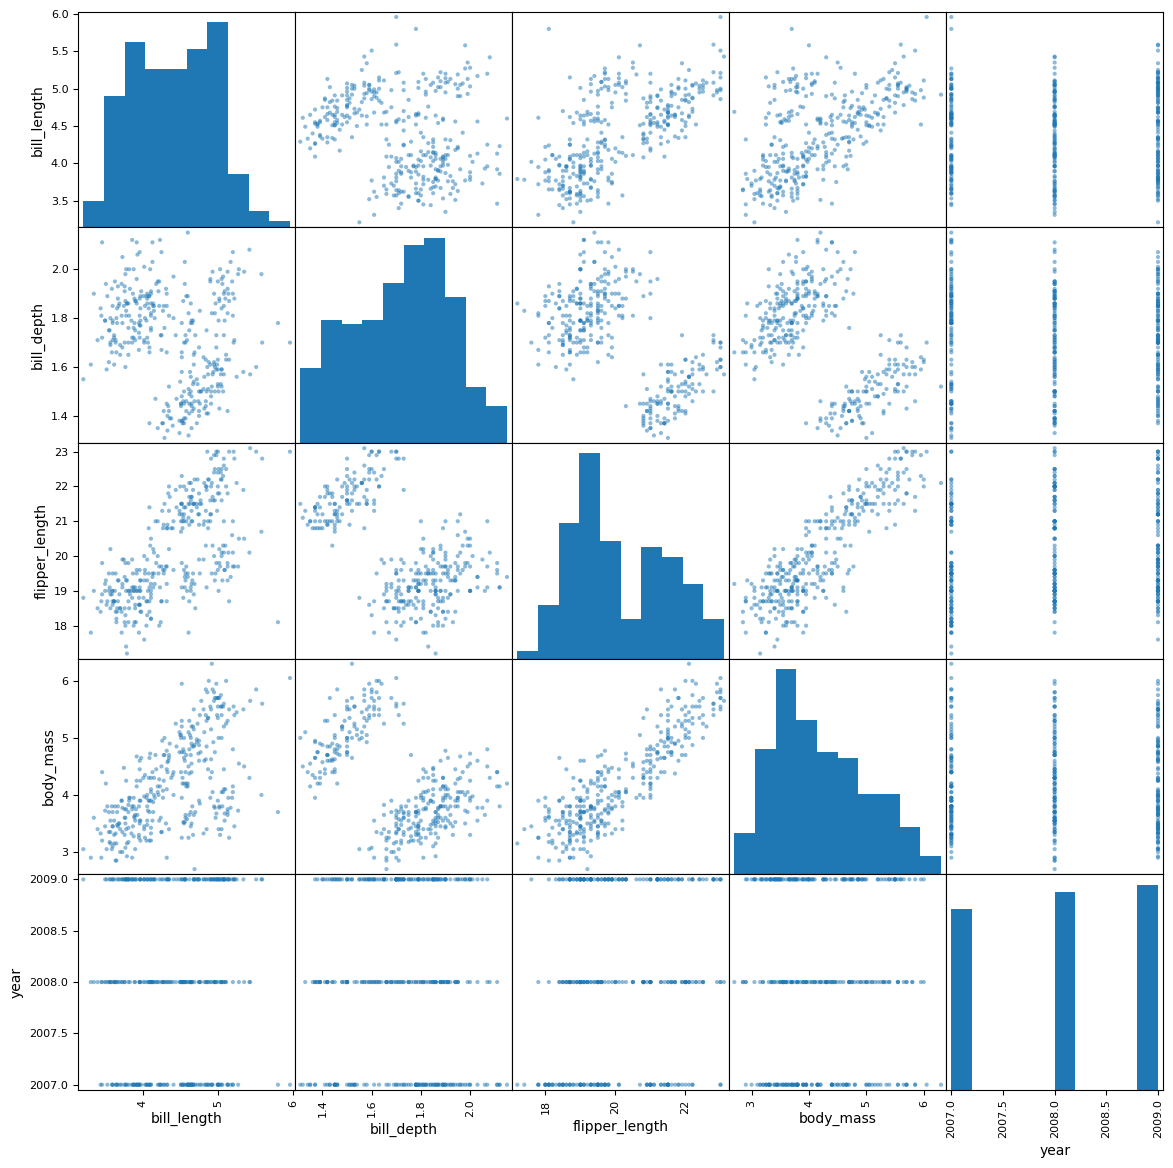

In [8]:
pd.plotting.scatter_matrix(penguins, figsize=(14,14))

In [10]:
#I combine all my predictor variables into one dataframe
X = penguins[[
             'bill_length',
             'bill_depth',
             'flipper_length',
             'year'
             ]]
Y = penguins['body_mass'].to_numpy()

In [31]:
with pm.Model() as model_penguin:
    s = pm.HalfNormal('s',1)
    μ = pmb.BART("μ", X, Y, m=50)
    y = pm.Normal("y", mu=μ, sigma=s, observed=Y)
    idata_penguin = pm.sample(compute_convergence_checks=False)

Output()

In [32]:
pm.sample_posterior_predictive(idata_penguin, model_penguin, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

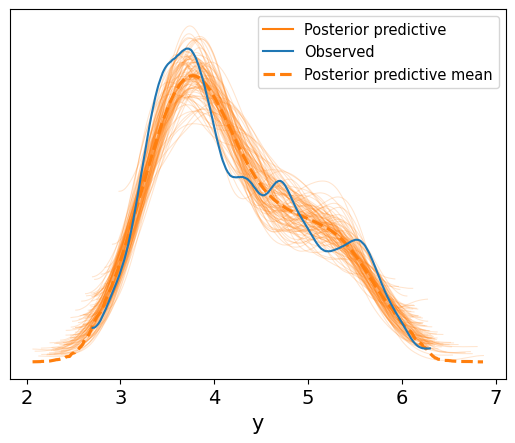

In [33]:
ax = az.plot_ppc(idata_penguin, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [34]:
posterior_mean = idata_penguin.posterior["μ"]

μ_hdi = az.hdi(ary=idata_penguin, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_penguin, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


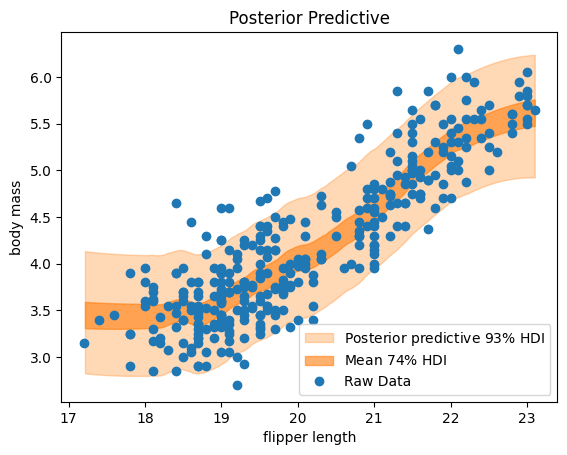

In [37]:
idx = np.argsort(X.to_numpy()[:, 2])
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 2],
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive $93\%$ HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 2],
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean $74\%$ HDI"},
)
ax.plot(penguins['flipper_length'], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="flipper length",
    ylabel="body mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I think the plot above captures the true association fairly well, given that the HDIs seem to align with the upward linear trend in the data and the 93% HDI includes most of the points.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='flipper_length'>, <Axes: xlabel='year'>],
      dtype=object)

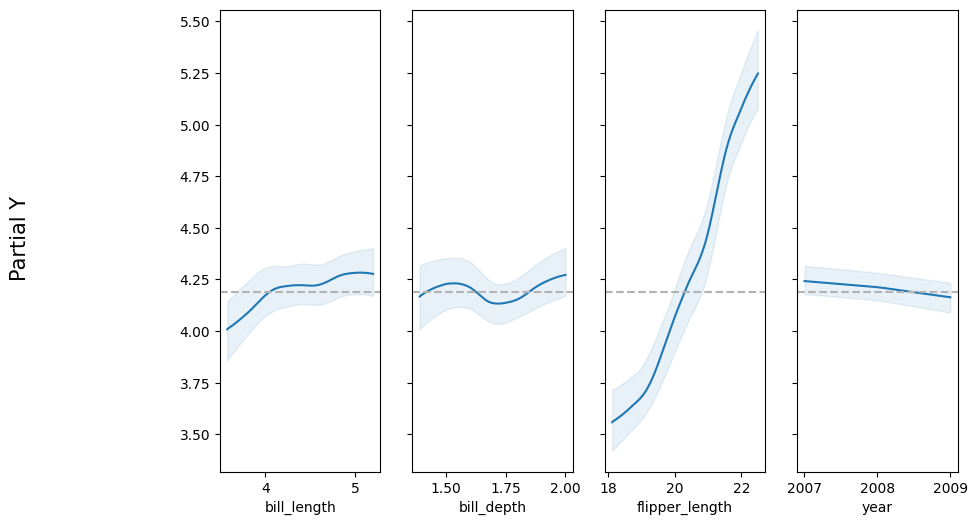

In [39]:
pmb.plot_pdp(μ, X, Y, grid=(1, 5), figsize = (12,6))

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='flipper_length'>, <Axes: xlabel='year'>],
      dtype=object)

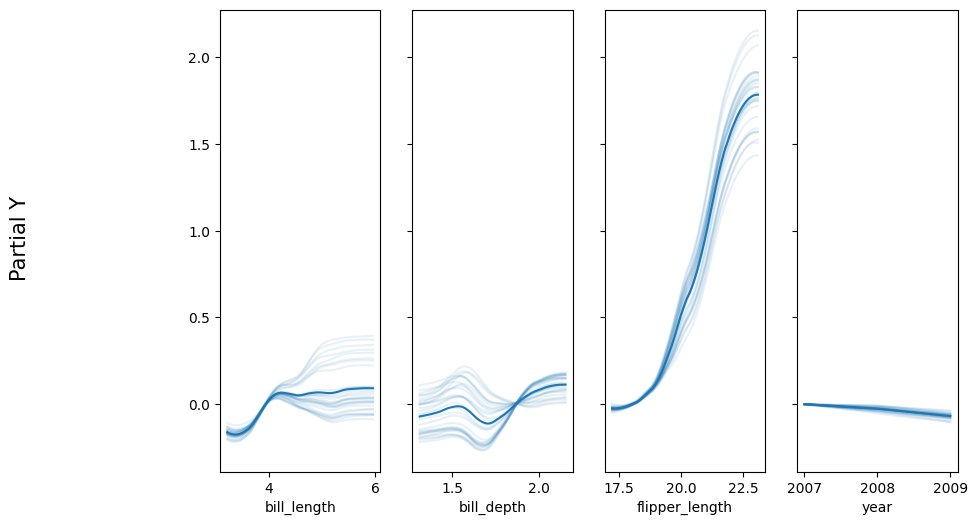

In [40]:
pmb.plot_ice(μ, X, Y, grid=(1, 5), figsize = (12,6))

In [41]:
vi_counties = pmb.compute_variable_importance(idata_penguin, μ, X)

<Axes: ylabel='R²'>

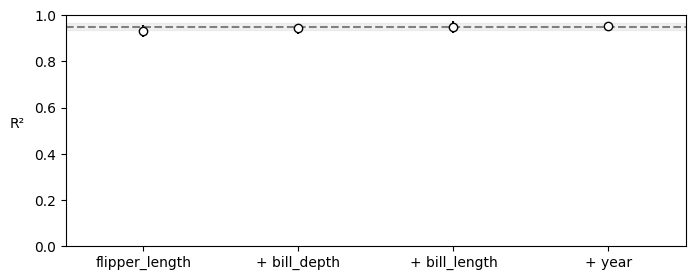

In [42]:
pmb.plot_variable_importance(vi_counties)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

The most important variable in predicting penguin body mass is their flipper length. The partial dependence plots for the predictor variables reveals a strong positive linear trend between flipper length and body mass while the other variables have a much smaller effect.

The ice plot lines for flipper length vs body mass are close enough to parallel that the trend seen in the pdp can be trusted. It seems that as flipper length increases, variance in resulting body mass increases, but, the ice plot variations being parallel, the effect of flipper length on body mass does not have a strong dependence on another predictor. The ice plot for bill depth has an inflection point reflecting that the effect of bill depth is dependent on another variable.

Furthermore, the variable importance plot for the set of predictors indicates flipper length alone can form a very powerful model with a coefficient of determination very close to one. This also reveals flipper length by itself could generate a model that does as well as a model with all predictors.